# Redes Neurais - Projeto 5
# Modelos Convolucionais - CNN
### Luis Filipe Menezes
#### RA: 164924

# Objetivos:

Este caderno consiste na quinta entrega da disciplina de Redes Neurais realizada no programa de Pós Graduação em Ciência da Computação durante meu mestrado.

O projeto tem como objetivo:

- Implementar uma rede CNN:
  - Usar MNIST, MNIST-Fashion, ou CIFAR-10 (ou outro dataset)

- Avaliar diferentes topologias (>5 topologias) e parâmetros
- Calcular a matriz de confusão para os dois melhores modelos
- Avaliar a diferença entre os modelos (top-2)

- Treinar uma rede MLP (já implementada no trabalho anterior) e
comparar com a rede CNN gerada: acurácia versus número de
parâmetros

# I. Importando e tratando o conjunto de dados:

Iremos utilizar o CIFAR-10

In [1]:
from keras.datasets import cifar10
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


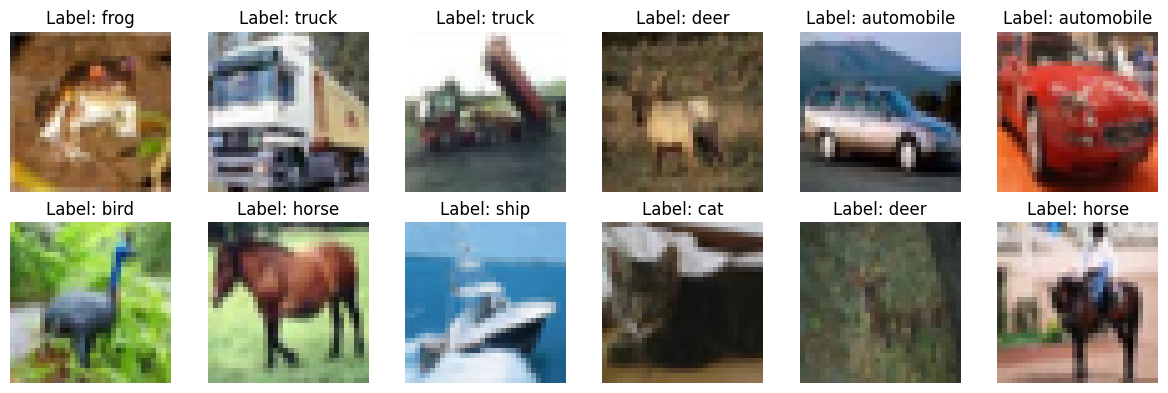

In [13]:
import matplotlib.pyplot as plt

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def display_images(images, labels_data, num_rows=2, num_cols=6):
    if num_rows * num_cols > len(images):
        print(f"Warning: Not enough images to fill a {num_rows}x{num_cols} grid. Displaying all available {len(images)} images.")
        num_to_display = len(images)
    else:
        num_to_display = num_rows * num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()

    for i in range(num_to_display):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {labels[labels_data[i][0]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display 6x2 subplots of the training dataset
display_images(train_images, train_labels, num_rows=2, num_cols=6)

# II. Configurando experimento:
Iremos analisar 5 topologias:

- 1 camada convolucional sem padding, seguida de 1 camada densa (100 neurônios).
- 1 camada convolucional com *zero-padding*, seguida de 1 camada densa (100 neurônios).
- 1 camada convolucional com *zero-padding* alterando $strides=2$, seguida de 1 camada densa (100 neurônios).
- 2 camadas convolucionais com *zero-padding*, seguido de 1 camada densa (100 neurônios).
- 2 camadas convolucionais com *zero-padding*, seguido de 2 camadas densas (100 neurônios).


In [14]:
import keras

images = keras.layers.Rescaling(scale=1./255)(train_images)
labels = keras.utils.to_categorical(train_labels, num_classes=10)

In [16]:
import keras

# Preprocess test images (scale pixel values to 0-1)
test_images_processed = keras.layers.Rescaling(scale=1./255)(test_images)

# One-hot encode test labels
test_labels_categorical = keras.utils.to_categorical(test_labels, num_classes=10)

print("Test images processed shape:", test_images_processed.shape)
print("Test labels categorical shape:", test_labels_categorical.shape)

Test images processed shape: (10000, 32, 32, 3)
Test labels categorical shape: (10000, 10)


# Task
Implement a reusable Keras CNN model function, then build, train, and evaluate five distinct CNN topologies on the CIFAR-10 dataset: (1) 1 conv layer (no padding) + 1 dense layer (100 neurons), (2) 1 conv layer (zero-padding) + 1 dense layer (100 neurons), (3) 1 conv layer (zero-padding, strides=2) + 1 dense layer (100 neurons), (4) 2 conv layers (zero-padding) + 1 dense layer (100 neurons), and (5) 2 conv layers (zero-padding) + 2 dense layers (100 neurons each). Compare their performance, identify the two best models, and calculate their confusion matrices. Finally, implement and evaluate an MLP model, comparing its accuracy and number of parameters with the best CNN model.

## Define Reusable Model Function

### Subtask:
Create a function to define, compile, train, and evaluate a Keras CNN model, taking architecture parameters as input to facilitate testing different topologies. This function should return training history and evaluation metrics.


**Reasoning**:
The subtask requires creating a Python function to define, compile, train, and evaluate Keras CNN models based on configurable architecture parameters. This code block defines such a function, which will be reusable for testing different topologies.



In [33]:
import keras
from keras import layers
from keras import models

def build_train_evaluate_cnn(
    train_images_data, train_labels_data,
    test_images_data, test_labels_data,
    conv_layer_configs, # e.g., [{'filters': 32, 'kernel_size': (3,3), 'padding': 'valid', 'strides': (1,1)}]
    dense_layer_units,  # e.g., [100] for one dense layer with 100 neurons
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    epochs=10,
    batch_size=32,
    input_shape=(32, 32, 3) # Default for CIFAR-10
):
    """
    Builds, compiles, trains, and evaluates a Keras CNN model.

    Args:
        train_images_data (np.array): Preprocessed training images.
        train_labels_data (np.array): One-hot encoded training labels.
        test_images_data (np.array): Preprocessed test images.
        test_labels_data (np.array): One-hot encoded test labels.
        conv_layer_configs (list): A list of dictionaries, each describing a Conv2D layer.
                                   Example: [{'filters': 32, 'kernel_size': (3,3), 'padding': 'valid', 'strides': (1,1)}]
        dense_layer_units (list): A list of integers, each representing the number of units
                                  in a Dense layer before the output layer.
        optimizer (str): Keras optimizer name (e.g., 'adam').
        loss (str): Keras loss function name (e.g., 'categorical_crossentropy').
        metrics (list): List of metrics to be evaluated by the model during training and testing.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        input_shape (tuple): The shape of the input images.

    Returns:
        tuple: A tuple containing:
            - history (keras.callbacks.History): Training history object.
            - test_loss (float): Loss value on the test dataset.
            - test_accuracy (float): Accuracy on the test dataset.
            - model (keras.models.Sequential): The trained Keras model.
    """
    model = models.Sequential()

    model.add(layers.Input(shape=input_shape))

    # Add convolutional layers
    for i, config in enumerate(conv_layer_configs):
        if i == 0:
            model.add(layers.Conv2D(
                filters=config.get('filters', 32),
                kernel_size=config.get('kernel_size', (3, 3)),
                padding=config.get('padding', 'valid'),
                strides=config.get('strides', (1, 1)),
                activation='relu'
            ))
        else:
            model.add(layers.Conv2D(
                filters=config.get('filters', 32),
                kernel_size=config.get('kernel_size', (3, 3)),
                padding=config.get('padding', 'valid'),
                strides=config.get('strides', (1, 1)),
                activation='relu'
            ))
        model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output for dense layers
    model.add(layers.Flatten())

    # Add dense layers
    for units in dense_layer_units:
        model.add(layers.Dense(units, activation='relu'))

    # Output layer (10 classes for CIFAR-10)
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)

    print("Model Summary for current topology:")
    model.summary()

    # Train the model
    history = model.fit(train_images_data, train_labels_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(test_images_data, test_labels_data),
                        verbose=0) # Set verbose to 0 to avoid cluttering output during experiments

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_images_data, test_labels_data, verbose=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return history, test_loss, test_accuracy, model

## Implement Topology 1

### Subtask:
Build, compile, train, and evaluate the first CNN topology: 1 convolutional layer (no padding) followed by 1 dense layer (100 neurons). Record its performance.


**Reasoning**:
I will define the convolutional and dense layer configurations for Topology 1 as specified, then call the `build_train_evaluate_cnn` function with these configurations and the preprocessed data, and finally print the test accuracy.



In [34]:
print('--- Topology 1: 1 Conv (no padding) + 1 Dense (100 neurons) ---')

# 1. Define the configuration for the convolutional layer
conv_config_1 = [{'filters': 32, 'kernel_size': (3, 3), 'padding': 'valid', 'strides': (1, 1)}]

# 2. Define the configuration for the dense layer
dense_config_1 = [24]

# 3. Call the build_train_evaluate_cnn function
history_1, test_loss_1, test_accuracy_1, model_1 = build_train_evaluate_cnn(
    train_images_data=images,
    train_labels_data=labels,
    test_images_data=test_images_processed,
    test_labels_data=test_labels_categorical,
    conv_layer_configs=conv_config_1,
    dense_layer_units=dense_config_1,
    epochs=10
)

# 5. Print the test accuracy to record the model's performance for Topology 1
print(f"Topology 1 Test Accuracy: {test_accuracy_1:.4f}")

--- Topology 1: 1 Conv (no padding) + 1 Dense (100 neurons) ---
Model Summary for current topology:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │       230,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,658 (904.91 KB)

 Trainable params: 231,658 (904.91 KB)

 Non-trainable params: 0 (0.00 B)

Test Loss: 1.1225, Test Accuracy: 0.6028
Topology 1 Test Accuracy: 0.6028


In [35]:
0+1

1